In [1]:
import pandas as pd
import numpy as np

# Leemos los datos

In [2]:
missing_values = ['n/a', 'na']
df_train = pd.read_csv('titanic/train.csv', na_values = missing_values)
df_test = pd.read_csv('titanic/test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
hist = df_train.hist(bins=20)

In [6]:
df_train['Title'] = df_train.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())
df_test['Title'] = df_test.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())

df_train['Title'] = df_train['Title'].replace('Mlle', 'Miss')
df_train['Title'] = df_train['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
df_train.Title.loc[ (df_train.Title !=  'Master') & (df_train.Title !=  'Mr') & (df_train.Title !=  'Miss') 
             & (df_train.Title !=  'Mrs')] = 'Others'


df_test['Title'] = df_test['Title'].replace('Mlle', 'Miss')
df_test['Title'] = df_test['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
df_test.Title.loc[ (df_test.Title !=  'Master') & (df_test.Title !=  'Mr') & (df_test.Title !=  'Miss') 
             & (df_test.Title !=  'Mrs')] = 'Others'

df_train = pd.concat([df_train, pd.get_dummies(df_train['Title'])], axis=1).drop(labels=['Name'], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Title'])], axis=1).drop(labels=['Name'], axis=1)

# create a new feature "Family"
df_train['Family'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['Family'] = df_test['SibSp'] + df_test['Parch'] + 1


df_train.Family = df_train.Family.map(lambda x: 0 if x > 4 else x)
df_test.Family = df_test.Family.map(lambda x: 0 if x > 4 else x)

df_train['Fare-bin'] = pd.qcut(df_train.Fare,5,labels=[1,2,3,4,5]).astype(int)
df_test['Fare-bin'] = pd.qcut(df_test.Fare,5,labels=[1,2,3,4,5]).astype(int)


/usr/lib/python3/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Limpiamos y procesamos los datos

In [7]:
def categorical_to_numerical(data_pd):
    data_pd['Sex'] = data_pd['Sex'].map({'male':0, 'female':1})
    data_pd['Embarked'] = data_pd['Embarked'].map({'C':0, 'Q':1, 'S':2})
    
    return data_pd

In [8]:
import pandas.api.types as ptypes

def test_categorical_to_numerical():
    df = pd.DataFrame({"PassengerId": [1, 2, 3],
                       "Sex": ['lala', 'male', 'female'],
                       "Embarked": ['S', 'C', 'Q']}) #,
                       # "hola": ['a', 'b', 'c']})
    
    df_cleaned = categorical_to_numerical(df)
    
    assert all(ptypes.is_numeric_dtype(df_cleaned[col]) for col in df_cleaned)
    # True
    # assert ptypes.is_string_dtype(df_cleaned['c'])
    # True
    # assert ptypes.is_datetime64_any_dtype(df_cleaned['d'])

test_categorical_to_numerical()

In [9]:
def clean_data(data_pd):
    cleaned_data = data_pd.dropna(axis=0)
    
    return cleaned_data

In [10]:
def test_clean_data():
    df = pd.DataFrame({"PassengerId": [1, np.nan, 3],
                       "Sex": [None, 'male', 'female'],
                       "Embarked": ['B', 'C', 'Q'],
                        "hola": ['null', 'b', 'c']})
    
    df_cleaned = clean_data(df)
    assert df_cleaned.isna().any().any() == False

test_clean_data()

In [11]:
def remove_duplicate_values(data_pd):
    return data_pd.drop_duplicates(keep='first', inplace=False)

In [12]:
def test_remove_duplicate_values():
    df = pd.DataFrame({"PassengerId": [1, np.nan, 3, 3],
                       "Sex": [None, 'male', 'female', 'female'],
                       "Embarked": ['B', 'C', 'Q', 'Q']})
    
    df_cleaned = remove_duplicate_values(df)
    assert (any(df_cleaned.duplicated())) == False
    
test_remove_duplicate_values()

In [13]:
df_train = categorical_to_numerical(df_train)
df_test = categorical_to_numerical(df_test)

df_train = clean_data(df_train)

In [14]:
df_train = df_train.drop(columns=['Title', 'Ticket', 'Cabin', 'PassengerId', 'Embarked', 'Pclass', 'SibSp', 'Parch'])
df_test = df_test.drop(columns=['Title','Ticket', 'Cabin', 'PassengerId', 'Embarked', 'Pclass', 'SibSp', 'Parch'])

# Matriz de correlacion

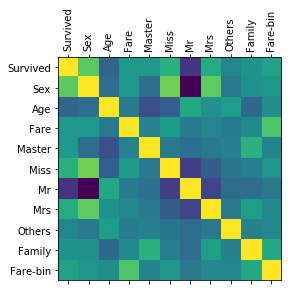

In [15]:
import matplotlib.pyplot as plt

plt.matshow(df_train.corr())
tick_marks = [i for i in range(len(df_train.columns))]
plt.xticks(tick_marks, df_train.columns, rotation='vertical')
plt.yticks(tick_marks, df_train.columns)
plt.show()

In [16]:
df_train.head()

,Survived,Sex,Age,Fare,Master,Miss,Mr,Mrs,Others,Family,Fare-bin
1,1,1,38.0,71.2833,0,0,0,1,0,2,5
3,1,1,35.0,53.1000,0,0,0,1,0,2,5
6,0,0,54.0,51.8625,0,0,1,0,0,1,5
10,1,1,4.0,16.7000,0,1,0,0,0,3,3
11,1,1,58.0,26.5500,0,1,0,0,0,1,4


# Definimos el modelo

In [17]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.models import Sequential
from keras import optimizers

Using TensorFlow backend.


In [18]:
y_train = df_train['Survived']
x_train = df_train.drop(columns=['Survived'])
feature_vector_length = x_train.shape[1]

# Sobreentrenamos el modelo con mas neuronas

In [19]:
def model_arquitecture():
    
    # Initialising the NN
    model = Sequential()

    # layers
    model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu', input_dim = feature_vector_length))
    model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

    # summary
    model.summary()
        
    adam = optimizers.Adam(lr=0.01, decay=1e-5)
    
    # Compiling the NN
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model


In [20]:
model = model_arquitecture()
feature_vector_length

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


10

In [21]:
training = model.fit(x_train[:40], y_train[:40], epochs=1000, batch_size=32, validation_split=0.2, verbose=2)

Train on 32 samples, validate on 8 samples
Epoch 1/1000
 - 0s - loss: 0.6932 - acc: 0.3438 - val_loss: 0.7105 - val_acc: 0.1250
Epoch 2/1000
 - 0s - loss: 0.6899 - acc: 0.5312 - val_loss: 0.7567 - val_acc: 0.1250
Epoch 3/1000
 - 0s - loss: 0.6822 - acc: 0.5312 - val_loss: 0.8806 - val_acc: 0.1250
Epoch 4/1000
 - 0s - loss: 0.6728 - acc: 0.5312 - val_loss: 1.0784 - val_acc: 0.1250
Epoch 5/1000
 - 0s - loss: 0.6774 - acc: 0.5312 - val_loss: 1.0030 - val_acc: 0.1250
Epoch 6/1000
 - 0s - loss: 0.6661 - acc: 0.5312 - val_loss: 0.9177 - val_acc: 0.1250
Epoch 7/1000
 - 0s - loss: 0.6606 - acc: 0.5312 - val_loss: 0.8789 - val_acc: 0.1250
Epoch 8/1000
 - 0s - loss: 0.6584 - acc: 0.5312 - val_loss: 0.8881 - val_acc: 0.1250
Epoch 9/1000
 - 0s - loss: 0.6540 - acc: 0.5312 - val_loss: 0.9433 - val_acc: 0.0000e+00
Epoch 10/1000
 - 0s - loss: 0.6481 - acc: 0.5312 - val_loss: 1.0333 - val_acc: 0.0000e+00
Epoch 11/1000
 - 0s - loss: 0.6455 - acc: 0.6250 - val_loss: 1.0631 - val_acc: 0.0000e+00
Epoch 12

Epoch 96/1000
 - 0s - loss: 0.1952 - acc: 0.9375 - val_loss: 1.3171 - val_acc: 0.6250
Epoch 97/1000
 - 0s - loss: 0.1703 - acc: 0.9375 - val_loss: 1.5543 - val_acc: 0.6250
Epoch 98/1000
 - 0s - loss: 0.1798 - acc: 0.9375 - val_loss: 1.4382 - val_acc: 0.6250
Epoch 99/1000
 - 0s - loss: 0.1651 - acc: 0.9375 - val_loss: 1.1718 - val_acc: 0.6250
Epoch 100/1000
 - 0s - loss: 0.1717 - acc: 0.9375 - val_loss: 1.3137 - val_acc: 0.6250
Epoch 101/1000
 - 0s - loss: 0.1570 - acc: 0.9375 - val_loss: 1.5611 - val_acc: 0.6250
Epoch 102/1000
 - 0s - loss: 0.1646 - acc: 0.9375 - val_loss: 1.4023 - val_acc: 0.6250
Epoch 103/1000
 - 0s - loss: 0.1510 - acc: 0.9375 - val_loss: 1.2663 - val_acc: 0.7500
Epoch 104/1000
 - 0s - loss: 0.1589 - acc: 0.9688 - val_loss: 1.5591 - val_acc: 0.6250
Epoch 105/1000
 - 0s - loss: 0.1516 - acc: 0.9375 - val_loss: 1.5803 - val_acc: 0.6250
Epoch 106/1000
 - 0s - loss: 0.1461 - acc: 0.9375 - val_loss: 1.3864 - val_acc: 0.6250
Epoch 107/1000
 - 0s - loss: 0.1479 - acc: 0.96

Epoch 191/1000
 - 0s - loss: 0.1318 - acc: 0.9375 - val_loss: 1.6119 - val_acc: 0.6250
Epoch 192/1000
 - 0s - loss: 0.1309 - acc: 0.9375 - val_loss: 1.5987 - val_acc: 0.6250
Epoch 193/1000
 - 0s - loss: 0.1301 - acc: 0.9375 - val_loss: 1.5962 - val_acc: 0.6250
Epoch 194/1000
 - 0s - loss: 0.1296 - acc: 0.9375 - val_loss: 1.6128 - val_acc: 0.6250
Epoch 195/1000
 - 0s - loss: 0.1288 - acc: 0.9375 - val_loss: 1.6459 - val_acc: 0.6250
Epoch 196/1000
 - 0s - loss: 0.1280 - acc: 0.9375 - val_loss: 1.6829 - val_acc: 0.6250
Epoch 197/1000
 - 0s - loss: 0.1273 - acc: 0.9375 - val_loss: 1.7100 - val_acc: 0.6250
Epoch 198/1000
 - 0s - loss: 0.1268 - acc: 0.9375 - val_loss: 1.7196 - val_acc: 0.6250
Epoch 199/1000
 - 0s - loss: 0.1263 - acc: 0.9375 - val_loss: 1.7275 - val_acc: 0.6250
Epoch 200/1000
 - 0s - loss: 0.1254 - acc: 0.9375 - val_loss: 1.7385 - val_acc: 0.6250
Epoch 201/1000
 - 0s - loss: 0.1249 - acc: 0.9375 - val_loss: 1.7445 - val_acc: 0.6250
Epoch 202/1000
 - 0s - loss: 0.1243 - acc: 

 - 0s - loss: 0.0876 - acc: 0.9688 - val_loss: 3.2388 - val_acc: 0.6250
Epoch 286/1000
 - 0s - loss: 0.0931 - acc: 0.9688 - val_loss: 3.0622 - val_acc: 0.6250
Epoch 287/1000
 - 0s - loss: 0.0959 - acc: 0.9688 - val_loss: 3.1508 - val_acc: 0.6250
Epoch 288/1000
 - 0s - loss: 0.0887 - acc: 0.9688 - val_loss: 3.3340 - val_acc: 0.6250
Epoch 289/1000
 - 0s - loss: 0.1035 - acc: 0.9375 - val_loss: 3.0709 - val_acc: 0.6250
Epoch 290/1000
 - 0s - loss: 0.1060 - acc: 0.9688 - val_loss: 3.2890 - val_acc: 0.6250
Epoch 291/1000
 - 0s - loss: 0.0888 - acc: 0.9688 - val_loss: 3.3353 - val_acc: 0.6250
Epoch 292/1000
 - 0s - loss: 0.0926 - acc: 0.9688 - val_loss: 3.1521 - val_acc: 0.6250
Epoch 293/1000
 - 0s - loss: 0.0937 - acc: 0.9688 - val_loss: 3.2119 - val_acc: 0.6250
Epoch 294/1000
 - 0s - loss: 0.0877 - acc: 0.9688 - val_loss: 3.3567 - val_acc: 0.6250
Epoch 295/1000
 - 0s - loss: 0.0983 - acc: 0.9375 - val_loss: 3.1537 - val_acc: 0.6250
Epoch 296/1000
 - 0s - loss: 0.0879 - acc: 0.9688 - val_lo

Epoch 380/1000
 - 0s - loss: 0.2499 - acc: 0.9062 - val_loss: 1.2901 - val_acc: 0.5000
Epoch 381/1000
 - 0s - loss: 0.2331 - acc: 0.9062 - val_loss: 1.4418 - val_acc: 0.5000
Epoch 382/1000
 - 0s - loss: 0.2108 - acc: 0.9375 - val_loss: 1.6987 - val_acc: 0.5000
Epoch 383/1000
 - 0s - loss: 0.1959 - acc: 0.9375 - val_loss: 1.9850 - val_acc: 0.5000
Epoch 384/1000
 - 0s - loss: 0.2028 - acc: 0.9375 - val_loss: 2.0128 - val_acc: 0.5000
Epoch 385/1000
 - 0s - loss: 0.2045 - acc: 0.9062 - val_loss: 1.7621 - val_acc: 0.5000
Epoch 386/1000
 - 0s - loss: 0.1751 - acc: 0.9375 - val_loss: 1.4665 - val_acc: 0.5000
Epoch 387/1000
 - 0s - loss: 0.1699 - acc: 0.9688 - val_loss: 1.3155 - val_acc: 0.5000
Epoch 388/1000
 - 0s - loss: 0.1738 - acc: 0.9688 - val_loss: 1.3072 - val_acc: 0.6250
Epoch 389/1000
 - 0s - loss: 0.1694 - acc: 0.9688 - val_loss: 1.4241 - val_acc: 0.5000
Epoch 390/1000
 - 0s - loss: 0.1594 - acc: 0.9688 - val_loss: 1.6359 - val_acc: 0.5000
Epoch 391/1000
 - 0s - loss: 0.1573 - acc: 

Epoch 475/1000
 - 0s - loss: 0.0855 - acc: 0.9688 - val_loss: 3.1357 - val_acc: 0.5000
Epoch 476/1000
 - 0s - loss: 0.0849 - acc: 0.9688 - val_loss: 3.1563 - val_acc: 0.5000
Epoch 477/1000
 - 0s - loss: 0.0846 - acc: 0.9688 - val_loss: 3.1111 - val_acc: 0.6250
Epoch 478/1000
 - 0s - loss: 0.0842 - acc: 0.9688 - val_loss: 3.1352 - val_acc: 0.6250
Epoch 479/1000
 - 0s - loss: 0.0836 - acc: 0.9688 - val_loss: 3.1745 - val_acc: 0.6250
Epoch 480/1000
 - 0s - loss: 0.0834 - acc: 0.9688 - val_loss: 3.1786 - val_acc: 0.5000
Epoch 481/1000
 - 0s - loss: 0.0827 - acc: 0.9688 - val_loss: 3.1545 - val_acc: 0.6250
Epoch 482/1000
 - 0s - loss: 0.0821 - acc: 0.9688 - val_loss: 3.1307 - val_acc: 0.6250
Epoch 483/1000
 - 0s - loss: 0.0818 - acc: 0.9688 - val_loss: 3.1337 - val_acc: 0.6250
Epoch 484/1000
 - 0s - loss: 0.0813 - acc: 0.9688 - val_loss: 3.1447 - val_acc: 0.6250
Epoch 485/1000
 - 0s - loss: 0.0809 - acc: 0.9688 - val_loss: 3.1284 - val_acc: 0.6250
Epoch 486/1000
 - 0s - loss: 0.0804 - acc: 

 - 0s - loss: 0.0513 - acc: 0.9688 - val_loss: 3.2752 - val_acc: 0.6250
Epoch 570/1000
 - 0s - loss: 0.0511 - acc: 0.9688 - val_loss: 3.2800 - val_acc: 0.6250
Epoch 571/1000
 - 0s - loss: 0.0509 - acc: 0.9688 - val_loss: 3.2891 - val_acc: 0.6250
Epoch 572/1000
 - 0s - loss: 0.0505 - acc: 0.9688 - val_loss: 3.2881 - val_acc: 0.6250
Epoch 573/1000
 - 0s - loss: 0.0501 - acc: 0.9688 - val_loss: 3.2939 - val_acc: 0.6250
Epoch 574/1000
 - 0s - loss: 0.0500 - acc: 0.9688 - val_loss: 3.2789 - val_acc: 0.6250
Epoch 575/1000
 - 0s - loss: 0.0498 - acc: 0.9688 - val_loss: 3.2836 - val_acc: 0.6250
Epoch 576/1000
 - 0s - loss: 0.0495 - acc: 0.9688 - val_loss: 3.2981 - val_acc: 0.6250
Epoch 577/1000
 - 0s - loss: 0.0492 - acc: 0.9688 - val_loss: 3.2756 - val_acc: 0.6250
Epoch 578/1000
 - 0s - loss: 0.0491 - acc: 0.9688 - val_loss: 3.3090 - val_acc: 0.6250
Epoch 579/1000
 - 0s - loss: 0.0487 - acc: 0.9688 - val_loss: 3.3042 - val_acc: 0.6250
Epoch 580/1000
 - 0s - loss: 0.0484 - acc: 0.9688 - val_lo

Epoch 664/1000
 - 0s - loss: 0.0300 - acc: 0.9688 - val_loss: 3.2226 - val_acc: 0.6250
Epoch 665/1000
 - 0s - loss: 0.0293 - acc: 0.9688 - val_loss: 3.2732 - val_acc: 0.6250
Epoch 666/1000
 - 0s - loss: 0.0291 - acc: 0.9688 - val_loss: 3.3541 - val_acc: 0.6250
Epoch 667/1000
 - 0s - loss: 0.0299 - acc: 0.9688 - val_loss: 3.3778 - val_acc: 0.6250
Epoch 668/1000
 - 0s - loss: 0.0291 - acc: 0.9688 - val_loss: 3.3393 - val_acc: 0.6250
Epoch 669/1000
 - 0s - loss: 0.0285 - acc: 0.9688 - val_loss: 3.2956 - val_acc: 0.6250
Epoch 670/1000
 - 0s - loss: 0.0290 - acc: 0.9688 - val_loss: 3.2600 - val_acc: 0.6250
Epoch 671/1000
 - 0s - loss: 0.0293 - acc: 0.9688 - val_loss: 3.2483 - val_acc: 0.6250
Epoch 672/1000
 - 0s - loss: 0.0293 - acc: 0.9688 - val_loss: 3.2604 - val_acc: 0.6250
Epoch 673/1000
 - 0s - loss: 0.0290 - acc: 0.9688 - val_loss: 3.2828 - val_acc: 0.6250
Epoch 674/1000
 - 0s - loss: 0.0284 - acc: 0.9688 - val_loss: 3.3065 - val_acc: 0.6250
Epoch 675/1000
 - 0s - loss: 0.0278 - acc: 

 - 0s - loss: 0.0202 - acc: 1.0000 - val_loss: 3.3758 - val_acc: 0.6250
Epoch 759/1000
 - 0s - loss: 0.0200 - acc: 1.0000 - val_loss: 3.3784 - val_acc: 0.6250
Epoch 760/1000
 - 0s - loss: 0.0208 - acc: 1.0000 - val_loss: 3.3061 - val_acc: 0.6250
Epoch 761/1000
 - 0s - loss: 0.0202 - acc: 1.0000 - val_loss: 3.2721 - val_acc: 0.6250
Epoch 762/1000
 - 0s - loss: 0.0221 - acc: 1.0000 - val_loss: 3.2762 - val_acc: 0.6250
Epoch 763/1000
 - 0s - loss: 0.0203 - acc: 1.0000 - val_loss: 3.2883 - val_acc: 0.6250
Epoch 764/1000
 - 0s - loss: 0.0201 - acc: 1.0000 - val_loss: 3.2968 - val_acc: 0.6250
Epoch 765/1000
 - 0s - loss: 0.0219 - acc: 1.0000 - val_loss: 3.2923 - val_acc: 0.6250
Epoch 766/1000
 - 0s - loss: 0.0229 - acc: 1.0000 - val_loss: 3.2810 - val_acc: 0.6250
Epoch 767/1000
 - 0s - loss: 0.0223 - acc: 1.0000 - val_loss: 3.2786 - val_acc: 0.6250
Epoch 768/1000
 - 0s - loss: 0.0204 - acc: 1.0000 - val_loss: 3.2973 - val_acc: 0.6250
Epoch 769/1000
 - 0s - loss: 0.0197 - acc: 1.0000 - val_lo

Epoch 853/1000
 - 0s - loss: 0.0156 - acc: 1.0000 - val_loss: 3.3677 - val_acc: 0.6250
Epoch 854/1000
 - 0s - loss: 0.0153 - acc: 1.0000 - val_loss: 3.4000 - val_acc: 0.6250
Epoch 855/1000
 - 0s - loss: 0.0152 - acc: 1.0000 - val_loss: 3.4433 - val_acc: 0.6250
Epoch 856/1000
 - 0s - loss: 0.0161 - acc: 1.0000 - val_loss: 3.3945 - val_acc: 0.6250
Epoch 857/1000
 - 0s - loss: 0.0151 - acc: 1.0000 - val_loss: 3.3644 - val_acc: 0.6250
Epoch 858/1000
 - 0s - loss: 0.0153 - acc: 1.0000 - val_loss: 3.3357 - val_acc: 0.6250
Epoch 859/1000
 - 0s - loss: 0.0155 - acc: 1.0000 - val_loss: 3.3095 - val_acc: 0.6250
Epoch 860/1000
 - 0s - loss: 0.0157 - acc: 1.0000 - val_loss: 3.2897 - val_acc: 0.6250
Epoch 861/1000
 - 0s - loss: 0.0158 - acc: 1.0000 - val_loss: 3.2808 - val_acc: 0.6250
Epoch 862/1000
 - 0s - loss: 0.0157 - acc: 1.0000 - val_loss: 3.2856 - val_acc: 0.6250
Epoch 863/1000
 - 0s - loss: 0.0155 - acc: 1.0000 - val_loss: 3.3237 - val_acc: 0.6250
Epoch 864/1000
 - 0s - loss: 0.0153 - acc: 

 - 0s - loss: 0.0129 - acc: 1.0000 - val_loss: 3.2995 - val_acc: 0.6250
Epoch 948/1000
 - 0s - loss: 0.0129 - acc: 1.0000 - val_loss: 3.3154 - val_acc: 0.6250
Epoch 949/1000
 - 0s - loss: 0.0127 - acc: 1.0000 - val_loss: 3.3398 - val_acc: 0.6250
Epoch 950/1000
 - 0s - loss: 0.0124 - acc: 1.0000 - val_loss: 3.3695 - val_acc: 0.6250
Epoch 951/1000
 - 0s - loss: 0.0121 - acc: 1.0000 - val_loss: 3.4033 - val_acc: 0.6250
Epoch 952/1000
 - 0s - loss: 0.0119 - acc: 1.0000 - val_loss: 3.4536 - val_acc: 0.6250
Epoch 953/1000
 - 0s - loss: 0.0117 - acc: 1.0000 - val_loss: 3.5033 - val_acc: 0.6250
Epoch 954/1000
 - 0s - loss: 0.0116 - acc: 1.0000 - val_loss: 3.5459 - val_acc: 0.6250
Epoch 955/1000
 - 0s - loss: 0.0115 - acc: 1.0000 - val_loss: 3.5799 - val_acc: 0.6250
Epoch 956/1000
 - 0s - loss: 0.0141 - acc: 1.0000 - val_loss: 3.4871 - val_acc: 0.6250
Epoch 957/1000
 - 0s - loss: 0.0115 - acc: 1.0000 - val_loss: 3.4206 - val_acc: 0.6250
Epoch 958/1000
 - 0s - loss: 0.0116 - acc: 1.0000 - val_lo

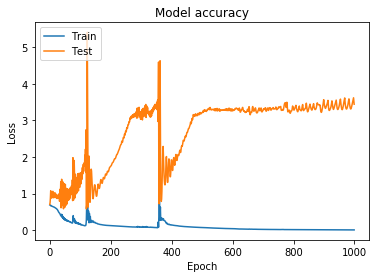

In [22]:
# Plot training & validation accuracy values
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Entrenamos con todo el dataset

In [23]:
model_data = model_arquitecture()
training_data = model_data.fit(x_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________
Train on 146 samples, validate on 37 samples
Epoch 1/1000
 - 0s - loss: 0.6773 - acc: 0.5890 - val_loss: 0.5604 - val_acc: 0.7297
Epoch 2/1000
 - 0s - loss: 0.6855 - acc: 0.6575 - val_loss: 0.5854 - val_acc: 0.7297
Epoch 3/1000
 - 0s - loss: 0.6582 -

Epoch 86/1000
 - 0s - loss: 0.3982 - acc: 0.7740 - val_loss: 0.3024 - val_acc: 0.8649
Epoch 87/1000
 - 0s - loss: 0.3858 - acc: 0.7603 - val_loss: 0.2978 - val_acc: 0.8649
Epoch 88/1000
 - 0s - loss: 0.3767 - acc: 0.7603 - val_loss: 0.3403 - val_acc: 0.8378
Epoch 89/1000
 - 0s - loss: 0.3852 - acc: 0.7603 - val_loss: 0.2946 - val_acc: 0.8649
Epoch 90/1000
 - 0s - loss: 0.3949 - acc: 0.7534 - val_loss: 0.3588 - val_acc: 0.8649
Epoch 91/1000
 - 0s - loss: 0.3958 - acc: 0.7603 - val_loss: 0.2917 - val_acc: 0.8108
Epoch 92/1000
 - 0s - loss: 0.3852 - acc: 0.7740 - val_loss: 0.3430 - val_acc: 0.8649
Epoch 93/1000
 - 0s - loss: 0.3823 - acc: 0.7671 - val_loss: 0.2816 - val_acc: 0.8649
Epoch 94/1000
 - 0s - loss: 0.3990 - acc: 0.7603 - val_loss: 0.3036 - val_acc: 0.8649
Epoch 95/1000
 - 0s - loss: 0.3722 - acc: 0.7740 - val_loss: 0.2984 - val_acc: 0.8649
Epoch 96/1000
 - 0s - loss: 0.3855 - acc: 0.7877 - val_loss: 0.2936 - val_acc: 0.8378
Epoch 97/1000
 - 0s - loss: 0.4081 - acc: 0.7603 - val

Epoch 181/1000
 - 0s - loss: 0.3450 - acc: 0.8082 - val_loss: 0.3085 - val_acc: 0.8108
Epoch 182/1000
 - 0s - loss: 0.3379 - acc: 0.7945 - val_loss: 0.2935 - val_acc: 0.8378
Epoch 183/1000
 - 0s - loss: 0.3346 - acc: 0.7945 - val_loss: 0.3009 - val_acc: 0.8378
Epoch 184/1000
 - 0s - loss: 0.3559 - acc: 0.8014 - val_loss: 0.3169 - val_acc: 0.8378
Epoch 185/1000
 - 0s - loss: 0.3884 - acc: 0.7877 - val_loss: 0.3095 - val_acc: 0.8108
Epoch 186/1000
 - 0s - loss: 0.3941 - acc: 0.7671 - val_loss: 0.4558 - val_acc: 0.8108
Epoch 187/1000
 - 0s - loss: 0.4071 - acc: 0.7603 - val_loss: 0.2924 - val_acc: 0.8378
Epoch 188/1000
 - 0s - loss: 0.3565 - acc: 0.7877 - val_loss: 0.2964 - val_acc: 0.8108
Epoch 189/1000
 - 0s - loss: 0.3617 - acc: 0.7877 - val_loss: 0.3480 - val_acc: 0.8649
Epoch 190/1000
 - 0s - loss: 0.3655 - acc: 0.7877 - val_loss: 0.3150 - val_acc: 0.7838
Epoch 191/1000
 - 0s - loss: 0.3697 - acc: 0.7671 - val_loss: 0.2837 - val_acc: 0.8378
Epoch 192/1000
 - 0s - loss: 0.3599 - acc: 

 - 0s - loss: 0.3550 - acc: 0.8014 - val_loss: 0.3236 - val_acc: 0.7838
Epoch 276/1000
 - 0s - loss: 0.3568 - acc: 0.8014 - val_loss: 0.3204 - val_acc: 0.7838
Epoch 277/1000
 - 0s - loss: 0.3522 - acc: 0.8014 - val_loss: 0.3180 - val_acc: 0.8108
Epoch 278/1000
 - 0s - loss: 0.3497 - acc: 0.8082 - val_loss: 0.3210 - val_acc: 0.8378
Epoch 279/1000
 - 0s - loss: 0.3494 - acc: 0.8082 - val_loss: 0.3312 - val_acc: 0.8378
Epoch 280/1000
 - 0s - loss: 0.3589 - acc: 0.8082 - val_loss: 0.3355 - val_acc: 0.7838
Epoch 281/1000
 - 0s - loss: 0.3469 - acc: 0.8014 - val_loss: 0.3100 - val_acc: 0.8649
Epoch 282/1000
 - 0s - loss: 0.3497 - acc: 0.7945 - val_loss: 0.3123 - val_acc: 0.8108
Epoch 283/1000
 - 0s - loss: 0.3456 - acc: 0.7945 - val_loss: 0.3125 - val_acc: 0.8378
Epoch 284/1000
 - 0s - loss: 0.3765 - acc: 0.8014 - val_loss: 0.3223 - val_acc: 0.8108
Epoch 285/1000
 - 0s - loss: 0.3948 - acc: 0.7603 - val_loss: 0.3296 - val_acc: 0.8108
Epoch 286/1000
 - 0s - loss: 0.3698 - acc: 0.7877 - val_lo

Epoch 370/1000
 - 0s - loss: 0.5366 - acc: 0.7123 - val_loss: 0.5580 - val_acc: 0.6216
Epoch 371/1000
 - 0s - loss: 0.5403 - acc: 0.6712 - val_loss: 0.5356 - val_acc: 0.7027
Epoch 372/1000
 - 0s - loss: 0.4972 - acc: 0.7466 - val_loss: 0.5081 - val_acc: 0.6486
Epoch 373/1000
 - 0s - loss: 0.4429 - acc: 0.7671 - val_loss: 0.4565 - val_acc: 0.7838
Epoch 374/1000
 - 0s - loss: 0.3983 - acc: 0.7603 - val_loss: 0.4053 - val_acc: 0.7568
Epoch 375/1000
 - 0s - loss: 0.4294 - acc: 0.7877 - val_loss: 0.4519 - val_acc: 0.7568
Epoch 376/1000
 - 0s - loss: 0.4011 - acc: 0.7534 - val_loss: 0.4311 - val_acc: 0.7297
Epoch 377/1000
 - 0s - loss: 0.4082 - acc: 0.7877 - val_loss: 0.4154 - val_acc: 0.7027
Epoch 378/1000
 - 0s - loss: 0.3972 - acc: 0.8219 - val_loss: 0.3924 - val_acc: 0.7297
Epoch 379/1000
 - 0s - loss: 0.3679 - acc: 0.7945 - val_loss: 0.3894 - val_acc: 0.7838
Epoch 380/1000
 - 0s - loss: 0.3785 - acc: 0.7877 - val_loss: 0.3902 - val_acc: 0.7297
Epoch 381/1000
 - 0s - loss: 0.3866 - acc: 

 - 0s - loss: 0.4760 - acc: 0.7534 - val_loss: 0.4121 - val_acc: 0.7838
Epoch 465/1000
 - 0s - loss: 0.4157 - acc: 0.7877 - val_loss: 0.3929 - val_acc: 0.7297
Epoch 466/1000
 - 0s - loss: 0.4045 - acc: 0.8014 - val_loss: 0.3776 - val_acc: 0.8108
Epoch 467/1000
 - 0s - loss: 0.3809 - acc: 0.8082 - val_loss: 0.3336 - val_acc: 0.8649
Epoch 468/1000
 - 0s - loss: 0.3527 - acc: 0.7945 - val_loss: 0.3029 - val_acc: 0.8919
Epoch 469/1000
 - 0s - loss: 0.3732 - acc: 0.7877 - val_loss: 0.3117 - val_acc: 0.8108
Epoch 470/1000
 - 0s - loss: 0.3673 - acc: 0.7740 - val_loss: 0.3470 - val_acc: 0.8108
Epoch 471/1000
 - 0s - loss: 0.3543 - acc: 0.8014 - val_loss: 0.3332 - val_acc: 0.8108
Epoch 472/1000
 - 0s - loss: 0.3409 - acc: 0.8082 - val_loss: 0.3012 - val_acc: 0.7838
Epoch 473/1000
 - 0s - loss: 0.3520 - acc: 0.7877 - val_loss: 0.3192 - val_acc: 0.8108
Epoch 474/1000
 - 0s - loss: 0.3488 - acc: 0.8082 - val_loss: 0.3228 - val_acc: 0.8378
Epoch 475/1000
 - 0s - loss: 0.3479 - acc: 0.8219 - val_lo

Epoch 559/1000
 - 0s - loss: 0.3172 - acc: 0.8356 - val_loss: 0.3189 - val_acc: 0.7838
Epoch 560/1000
 - 0s - loss: 0.3155 - acc: 0.8288 - val_loss: 0.3113 - val_acc: 0.8378
Epoch 561/1000
 - 0s - loss: 0.3187 - acc: 0.8288 - val_loss: 0.3083 - val_acc: 0.8378
Epoch 562/1000
 - 0s - loss: 0.3150 - acc: 0.8219 - val_loss: 0.3141 - val_acc: 0.8108
Epoch 563/1000
 - 0s - loss: 0.3126 - acc: 0.8288 - val_loss: 0.3058 - val_acc: 0.8108
Epoch 564/1000
 - 0s - loss: 0.3131 - acc: 0.8288 - val_loss: 0.3036 - val_acc: 0.8108
Epoch 565/1000
 - 0s - loss: 0.3112 - acc: 0.8219 - val_loss: 0.3190 - val_acc: 0.7838
Epoch 566/1000
 - 0s - loss: 0.3155 - acc: 0.8288 - val_loss: 0.3081 - val_acc: 0.7838
Epoch 567/1000
 - 0s - loss: 0.3122 - acc: 0.8288 - val_loss: 0.2882 - val_acc: 0.8378
Epoch 568/1000
 - 0s - loss: 0.3139 - acc: 0.8288 - val_loss: 0.3072 - val_acc: 0.8108
Epoch 569/1000
 - 0s - loss: 0.3114 - acc: 0.8219 - val_loss: 0.3208 - val_acc: 0.8108
Epoch 570/1000
 - 0s - loss: 0.3168 - acc: 

 - 0s - loss: 0.3115 - acc: 0.8493 - val_loss: 0.4618 - val_acc: 0.8108
Epoch 654/1000
 - 0s - loss: 0.3314 - acc: 0.8219 - val_loss: 0.3122 - val_acc: 0.8108
Epoch 655/1000
 - 0s - loss: 0.3271 - acc: 0.8151 - val_loss: 0.2971 - val_acc: 0.8649
Epoch 656/1000
 - 0s - loss: 0.3168 - acc: 0.8425 - val_loss: 0.2849 - val_acc: 0.8378
Epoch 657/1000
 - 0s - loss: 0.3080 - acc: 0.8288 - val_loss: 0.2883 - val_acc: 0.8108
Epoch 658/1000
 - 0s - loss: 0.3062 - acc: 0.8219 - val_loss: 0.2931 - val_acc: 0.7568
Epoch 659/1000
 - 0s - loss: 0.3082 - acc: 0.8151 - val_loss: 0.3020 - val_acc: 0.8108
Epoch 660/1000
 - 0s - loss: 0.3046 - acc: 0.8219 - val_loss: 0.2847 - val_acc: 0.8108
Epoch 661/1000
 - 0s - loss: 0.3039 - acc: 0.8219 - val_loss: 0.3091 - val_acc: 0.7838
Epoch 662/1000
 - 0s - loss: 0.2990 - acc: 0.8288 - val_loss: 0.3194 - val_acc: 0.7838
Epoch 663/1000
 - 0s - loss: 0.2996 - acc: 0.8425 - val_loss: 0.3271 - val_acc: 0.8108
Epoch 664/1000
 - 0s - loss: 0.2982 - acc: 0.8425 - val_lo

Epoch 748/1000
 - 0s - loss: 0.3298 - acc: 0.8288 - val_loss: 0.3046 - val_acc: 0.7838
Epoch 749/1000
 - 0s - loss: 0.3347 - acc: 0.8219 - val_loss: 0.3288 - val_acc: 0.8378
Epoch 750/1000
 - 0s - loss: 0.3292 - acc: 0.8014 - val_loss: 0.3029 - val_acc: 0.8378
Epoch 751/1000
 - 0s - loss: 0.3150 - acc: 0.8356 - val_loss: 0.2995 - val_acc: 0.7838
Epoch 752/1000
 - 0s - loss: 0.3088 - acc: 0.8356 - val_loss: 0.2930 - val_acc: 0.8378
Epoch 753/1000
 - 0s - loss: 0.3550 - acc: 0.8151 - val_loss: 0.3048 - val_acc: 0.8108
Epoch 754/1000
 - 0s - loss: 0.3162 - acc: 0.8288 - val_loss: 0.3894 - val_acc: 0.7838
Epoch 755/1000
 - 0s - loss: 0.4411 - acc: 0.8356 - val_loss: 0.6144 - val_acc: 0.7838
Epoch 756/1000
 - 0s - loss: 0.4457 - acc: 0.8356 - val_loss: 0.5075 - val_acc: 0.7838
Epoch 757/1000
 - 0s - loss: 0.4204 - acc: 0.8014 - val_loss: 0.4469 - val_acc: 0.8108
Epoch 758/1000
 - 0s - loss: 0.4551 - acc: 0.7466 - val_loss: 0.4512 - val_acc: 0.7568
Epoch 759/1000
 - 0s - loss: 0.4437 - acc: 

 - 0s - loss: 0.3265 - acc: 0.8356 - val_loss: 0.2667 - val_acc: 0.8649
Epoch 843/1000
 - 0s - loss: 0.3116 - acc: 0.8151 - val_loss: 0.3000 - val_acc: 0.8649
Epoch 844/1000
 - 0s - loss: 0.3187 - acc: 0.8151 - val_loss: 0.2865 - val_acc: 0.8919
Epoch 845/1000
 - 0s - loss: 0.3106 - acc: 0.8288 - val_loss: 0.2768 - val_acc: 0.8919
Epoch 846/1000
 - 0s - loss: 0.3084 - acc: 0.8288 - val_loss: 0.2656 - val_acc: 0.8919
Epoch 847/1000
 - 0s - loss: 0.3132 - acc: 0.8151 - val_loss: 0.2616 - val_acc: 0.8919
Epoch 848/1000
 - 0s - loss: 0.3035 - acc: 0.8356 - val_loss: 0.2653 - val_acc: 0.8649
Epoch 849/1000
 - 0s - loss: 0.3074 - acc: 0.8219 - val_loss: 0.2618 - val_acc: 0.8919
Epoch 850/1000
 - 0s - loss: 0.3075 - acc: 0.8219 - val_loss: 0.2606 - val_acc: 0.8649
Epoch 851/1000
 - 0s - loss: 0.3040 - acc: 0.8219 - val_loss: 0.2562 - val_acc: 0.8919
Epoch 852/1000
 - 0s - loss: 0.3030 - acc: 0.8288 - val_loss: 0.2619 - val_acc: 0.8919
Epoch 853/1000
 - 0s - loss: 0.3425 - acc: 0.7808 - val_lo

Epoch 937/1000
 - 0s - loss: 0.3293 - acc: 0.8082 - val_loss: 0.2527 - val_acc: 0.8378
Epoch 938/1000
 - 0s - loss: 0.3298 - acc: 0.8356 - val_loss: 0.2677 - val_acc: 0.8378
Epoch 939/1000
 - 0s - loss: 0.3063 - acc: 0.8562 - val_loss: 0.3917 - val_acc: 0.7838
Epoch 940/1000
 - 0s - loss: 0.3239 - acc: 0.8562 - val_loss: 0.2472 - val_acc: 0.8378
Epoch 941/1000
 - 0s - loss: 0.3117 - acc: 0.8493 - val_loss: 0.2465 - val_acc: 0.8378
Epoch 942/1000
 - 0s - loss: 0.3173 - acc: 0.8288 - val_loss: 0.2503 - val_acc: 0.8649
Epoch 943/1000
 - 0s - loss: 0.3099 - acc: 0.8288 - val_loss: 0.2518 - val_acc: 0.8649
Epoch 944/1000
 - 0s - loss: 0.3070 - acc: 0.8425 - val_loss: 0.2496 - val_acc: 0.8378
Epoch 945/1000
 - 0s - loss: 0.3085 - acc: 0.8425 - val_loss: 0.2815 - val_acc: 0.8108
Epoch 946/1000
 - 0s - loss: 0.2980 - acc: 0.8425 - val_loss: 0.3020 - val_acc: 0.8649
Epoch 947/1000
 - 0s - loss: 0.2892 - acc: 0.8562 - val_loss: 0.3070 - val_acc: 0.8108
Epoch 948/1000
 - 0s - loss: 0.3009 - acc: 

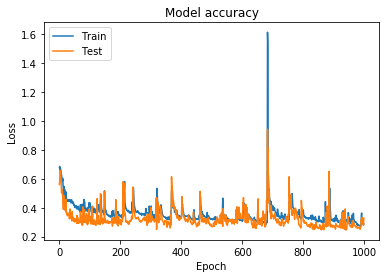

In [24]:
# Plot training & validation accuracy values
plt.plot(training_data.history['loss'])
plt.plot(training_data.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Sobre entrenamos la red con menos neuronas

In [25]:
def model_arquitecture2():
    model = Sequential()
    model.add(Dense(units=16, input_dim=feature_vector_length, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=4, activation='relu'))   
    model.add(Dense(units=1, activation='sigmoid'))
    # Compile model
    adam = optimizers.Adam(lr=0.01, decay=1e-5)

    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [26]:
model2 = model_arquitecture2()
feature_vector_length

10

In [27]:
training2 = model2.fit(x_train[:40], y_train[:40], epochs=600, batch_size=32, validation_split=0.2, verbose=2)

Train on 32 samples, validate on 8 samples
Epoch 1/600
 - 1s - loss: 0.8665 - acc: 0.6250 - val_loss: 1.4262 - val_acc: 0.0000e+00
Epoch 2/600
 - 0s - loss: 0.8104 - acc: 0.5938 - val_loss: 1.1357 - val_acc: 0.0000e+00
Epoch 3/600
 - 0s - loss: 0.6962 - acc: 0.6250 - val_loss: 0.7170 - val_acc: 0.6250
Epoch 4/600
 - 0s - loss: 0.5987 - acc: 0.6875 - val_loss: 0.5480 - val_acc: 0.6250
Epoch 5/600
 - 0s - loss: 0.6501 - acc: 0.6250 - val_loss: 0.5323 - val_acc: 0.6250
Epoch 6/600
 - 0s - loss: 0.6212 - acc: 0.6562 - val_loss: 0.6609 - val_acc: 0.6250
Epoch 7/600
 - 0s - loss: 0.5668 - acc: 0.7188 - val_loss: 0.8554 - val_acc: 0.3750
Epoch 8/600
 - 0s - loss: 0.5822 - acc: 0.7188 - val_loss: 0.9612 - val_acc: 0.1250
Epoch 9/600
 - 0s - loss: 0.6005 - acc: 0.7812 - val_loss: 0.9286 - val_acc: 0.1250
Epoch 10/600
 - 0s - loss: 0.5915 - acc: 0.8438 - val_loss: 0.8118 - val_acc: 0.3750
Epoch 11/600
 - 0s - loss: 0.5704 - acc: 0.8125 - val_loss: 0.6846 - val_acc: 0.6250
Epoch 12/600
 - 0s - lo

Epoch 97/600
 - 0s - loss: 0.1041 - acc: 0.9688 - val_loss: 1.3936 - val_acc: 0.5000
Epoch 98/600
 - 0s - loss: 0.1023 - acc: 0.9688 - val_loss: 1.3861 - val_acc: 0.5000
Epoch 99/600
 - 0s - loss: 0.1009 - acc: 0.9688 - val_loss: 1.4666 - val_acc: 0.5000
Epoch 100/600
 - 0s - loss: 0.0980 - acc: 0.9688 - val_loss: 1.4529 - val_acc: 0.5000
Epoch 101/600
 - 0s - loss: 0.0958 - acc: 0.9688 - val_loss: 1.4710 - val_acc: 0.5000
Epoch 102/600
 - 0s - loss: 0.0937 - acc: 0.9688 - val_loss: 1.5227 - val_acc: 0.5000
Epoch 103/600
 - 0s - loss: 0.0920 - acc: 0.9688 - val_loss: 1.5016 - val_acc: 0.5000
Epoch 104/600
 - 0s - loss: 0.0907 - acc: 0.9688 - val_loss: 1.5524 - val_acc: 0.5000
Epoch 105/600
 - 0s - loss: 0.0888 - acc: 0.9688 - val_loss: 1.5688 - val_acc: 0.5000
Epoch 106/600
 - 0s - loss: 0.0866 - acc: 0.9688 - val_loss: 1.5651 - val_acc: 0.5000
Epoch 107/600
 - 0s - loss: 0.0847 - acc: 0.9688 - val_loss: 1.6232 - val_acc: 0.5000
Epoch 108/600
 - 0s - loss: 0.0827 - acc: 0.9688 - val_lo

Epoch 193/600
 - 0s - loss: 0.0149 - acc: 1.0000 - val_loss: 3.1777 - val_acc: 0.5000
Epoch 194/600
 - 0s - loss: 0.0147 - acc: 1.0000 - val_loss: 3.2100 - val_acc: 0.5000
Epoch 195/600
 - 0s - loss: 0.0144 - acc: 1.0000 - val_loss: 3.2189 - val_acc: 0.5000
Epoch 196/600
 - 0s - loss: 0.0141 - acc: 1.0000 - val_loss: 3.2233 - val_acc: 0.5000
Epoch 197/600
 - 0s - loss: 0.0139 - acc: 1.0000 - val_loss: 3.2579 - val_acc: 0.5000
Epoch 198/600
 - 0s - loss: 0.0136 - acc: 1.0000 - val_loss: 3.2622 - val_acc: 0.5000
Epoch 199/600
 - 0s - loss: 0.0134 - acc: 1.0000 - val_loss: 3.2781 - val_acc: 0.5000
Epoch 200/600
 - 0s - loss: 0.0131 - acc: 1.0000 - val_loss: 3.3126 - val_acc: 0.5000
Epoch 201/600
 - 0s - loss: 0.0129 - acc: 1.0000 - val_loss: 3.3192 - val_acc: 0.5000
Epoch 202/600
 - 0s - loss: 0.0127 - acc: 1.0000 - val_loss: 3.3435 - val_acc: 0.5000
Epoch 203/600
 - 0s - loss: 0.0124 - acc: 1.0000 - val_loss: 3.3647 - val_acc: 0.5000
Epoch 204/600
 - 0s - loss: 0.0122 - acc: 1.0000 - val

Epoch 289/600
 - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 4.6974 - val_acc: 0.3750
Epoch 290/600
 - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 4.7073 - val_acc: 0.3750
Epoch 291/600
 - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 4.7141 - val_acc: 0.3750
Epoch 292/600
 - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 4.7192 - val_acc: 0.3750
Epoch 293/600
 - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 4.7249 - val_acc: 0.3750
Epoch 294/600
 - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 4.7312 - val_acc: 0.3750
Epoch 295/600
 - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 4.7348 - val_acc: 0.3750
Epoch 296/600
 - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 4.7356 - val_acc: 0.3750
Epoch 297/600
 - 0s - loss: 0.0033 - acc: 1.0000 - val_loss: 4.7374 - val_acc: 0.3750
Epoch 298/600
 - 0s - loss: 0.0033 - acc: 1.0000 - val_loss: 4.7450 - val_acc: 0.3750
Epoch 299/600
 - 0s - loss: 0.0033 - acc: 1.0000 - val_loss: 4.7544 - val_acc: 0.3750
Epoch 300/600
 - 0s - loss: 0.0032 - acc: 1.0000 - val

Epoch 385/600
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 5.1704 - val_acc: 0.3750
Epoch 386/600
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 5.1762 - val_acc: 0.3750
Epoch 387/600
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 5.1811 - val_acc: 0.3750
Epoch 388/600
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 5.1827 - val_acc: 0.3750
Epoch 389/600
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 5.1823 - val_acc: 0.3750
Epoch 390/600
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 5.1825 - val_acc: 0.3750
Epoch 391/600
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 5.1873 - val_acc: 0.3750
Epoch 392/600
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 5.1947 - val_acc: 0.3750
Epoch 393/600
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 5.2014 - val_acc: 0.3750
Epoch 394/600
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 5.2063 - val_acc: 0.3750
Epoch 395/600
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 5.2094 - val_acc: 0.3750
Epoch 396/600
 - 0s - loss: 0.0014 - acc: 1.0000 - val

 - 0s - loss: 8.5713e-04 - acc: 1.0000 - val_loss: 5.4934 - val_acc: 0.3750
Epoch 480/600
 - 0s - loss: 8.5248e-04 - acc: 1.0000 - val_loss: 5.4956 - val_acc: 0.3750
Epoch 481/600
 - 0s - loss: 8.4793e-04 - acc: 1.0000 - val_loss: 5.4987 - val_acc: 0.3750
Epoch 482/600
 - 0s - loss: 8.4344e-04 - acc: 1.0000 - val_loss: 5.5022 - val_acc: 0.3750
Epoch 483/600
 - 0s - loss: 8.3884e-04 - acc: 1.0000 - val_loss: 5.5060 - val_acc: 0.3750
Epoch 484/600
 - 0s - loss: 8.3426e-04 - acc: 1.0000 - val_loss: 5.5089 - val_acc: 0.3750
Epoch 485/600
 - 0s - loss: 8.3005e-04 - acc: 1.0000 - val_loss: 5.5117 - val_acc: 0.3750
Epoch 486/600
 - 0s - loss: 8.2569e-04 - acc: 1.0000 - val_loss: 5.5145 - val_acc: 0.3750
Epoch 487/600
 - 0s - loss: 8.2145e-04 - acc: 1.0000 - val_loss: 5.5170 - val_acc: 0.3750
Epoch 488/600
 - 0s - loss: 8.1726e-04 - acc: 1.0000 - val_loss: 5.5205 - val_acc: 0.3750
Epoch 489/600
 - 0s - loss: 8.1297e-04 - acc: 1.0000 - val_loss: 5.5245 - val_acc: 0.3750
Epoch 490/600
 - 0s - lo

Epoch 571/600
 - 0s - loss: 5.5222e-04 - acc: 1.0000 - val_loss: 5.7402 - val_acc: 0.3750
Epoch 572/600
 - 0s - loss: 5.4980e-04 - acc: 1.0000 - val_loss: 5.7442 - val_acc: 0.3750
Epoch 573/600
 - 0s - loss: 5.4748e-04 - acc: 1.0000 - val_loss: 5.7473 - val_acc: 0.3750
Epoch 574/600
 - 0s - loss: 5.4516e-04 - acc: 1.0000 - val_loss: 5.7488 - val_acc: 0.3750
Epoch 575/600
 - 0s - loss: 5.4283e-04 - acc: 1.0000 - val_loss: 5.7506 - val_acc: 0.3750
Epoch 576/600
 - 0s - loss: 5.4052e-04 - acc: 1.0000 - val_loss: 5.7532 - val_acc: 0.3750
Epoch 577/600
 - 0s - loss: 5.3820e-04 - acc: 1.0000 - val_loss: 5.7555 - val_acc: 0.3750
Epoch 578/600
 - 0s - loss: 5.3584e-04 - acc: 1.0000 - val_loss: 5.7580 - val_acc: 0.3750
Epoch 579/600
 - 0s - loss: 5.3364e-04 - acc: 1.0000 - val_loss: 5.7602 - val_acc: 0.3750
Epoch 580/600
 - 0s - loss: 5.3151e-04 - acc: 1.0000 - val_loss: 5.7632 - val_acc: 0.3750
Epoch 581/600
 - 0s - loss: 5.2934e-04 - acc: 1.0000 - val_loss: 5.7652 - val_acc: 0.3750
Epoch 582/

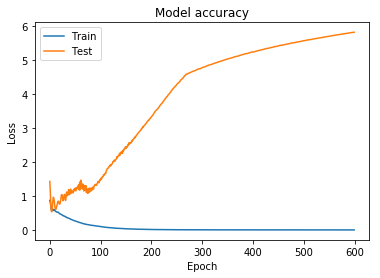

In [28]:
# Plot training & validation accuracy values
plt.plot(training2.history['loss'])
plt.plot(training2.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Entrenamos con todo el dataset

In [29]:
model2_data = model_arquitecture2()
training2_data = model2_data.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=2)

Train on 146 samples, validate on 37 samples
Epoch 1/200
 - 0s - loss: 8.0235 - acc: 0.3425 - val_loss: 5.1981 - val_acc: 0.2703
Epoch 2/200
 - 0s - loss: 2.5699 - acc: 0.3425 - val_loss: 0.7167 - val_acc: 0.4054
Epoch 3/200
 - 0s - loss: 0.6885 - acc: 0.5890 - val_loss: 0.6571 - val_acc: 0.7568
Epoch 4/200
 - 0s - loss: 0.6719 - acc: 0.6644 - val_loss: 0.6562 - val_acc: 0.7297
Epoch 5/200
 - 0s - loss: 0.6685 - acc: 0.6575 - val_loss: 0.6522 - val_acc: 0.7297
Epoch 6/200
 - 0s - loss: 0.6655 - acc: 0.6575 - val_loss: 0.6481 - val_acc: 0.7297
Epoch 7/200
 - 0s - loss: 0.6634 - acc: 0.6575 - val_loss: 0.6440 - val_acc: 0.7297
Epoch 8/200
 - 0s - loss: 0.6615 - acc: 0.6575 - val_loss: 0.6397 - val_acc: 0.7297
Epoch 9/200
 - 0s - loss: 0.6591 - acc: 0.6575 - val_loss: 0.6360 - val_acc: 0.7297
Epoch 10/200
 - 0s - loss: 0.6572 - acc: 0.6575 - val_loss: 0.6324 - val_acc: 0.7297
Epoch 11/200
 - 0s - loss: 0.6553 - acc: 0.6575 - val_loss: 0.6287 - val_acc: 0.7297
Epoch 12/200
 - 0s - loss: 0.

Epoch 97/200
 - 0s - loss: 0.6286 - acc: 0.6712 - val_loss: 0.5624 - val_acc: 0.7568
Epoch 98/200
 - 0s - loss: 0.6285 - acc: 0.6712 - val_loss: 0.5623 - val_acc: 0.7568
Epoch 99/200
 - 0s - loss: 0.6291 - acc: 0.6712 - val_loss: 0.5626 - val_acc: 0.7568
Epoch 100/200
 - 0s - loss: 0.6284 - acc: 0.6712 - val_loss: 0.5629 - val_acc: 0.7568
Epoch 101/200
 - 0s - loss: 0.6291 - acc: 0.6712 - val_loss: 0.5635 - val_acc: 0.7568
Epoch 102/200
 - 0s - loss: 0.6289 - acc: 0.6712 - val_loss: 0.5635 - val_acc: 0.7568
Epoch 103/200
 - 0s - loss: 0.6284 - acc: 0.6712 - val_loss: 0.5633 - val_acc: 0.7568
Epoch 104/200
 - 0s - loss: 0.6286 - acc: 0.6712 - val_loss: 0.5633 - val_acc: 0.7568
Epoch 105/200
 - 0s - loss: 0.6287 - acc: 0.6712 - val_loss: 0.5636 - val_acc: 0.7568
Epoch 106/200
 - 0s - loss: 0.6287 - acc: 0.6712 - val_loss: 0.5631 - val_acc: 0.7568
Epoch 107/200
 - 0s - loss: 0.6284 - acc: 0.6712 - val_loss: 0.5631 - val_acc: 0.7568
Epoch 108/200
 - 0s - loss: 0.6283 - acc: 0.6712 - val_lo

Epoch 193/200
 - 0s - loss: 0.6279 - acc: 0.6712 - val_loss: 0.5622 - val_acc: 0.7568
Epoch 194/200
 - 0s - loss: 0.6279 - acc: 0.6712 - val_loss: 0.5622 - val_acc: 0.7568
Epoch 195/200
 - 0s - loss: 0.6279 - acc: 0.6712 - val_loss: 0.5623 - val_acc: 0.7568
Epoch 196/200
 - 0s - loss: 0.6281 - acc: 0.6712 - val_loss: 0.5619 - val_acc: 0.7568
Epoch 197/200
 - 0s - loss: 0.6283 - acc: 0.6712 - val_loss: 0.5623 - val_acc: 0.7568
Epoch 198/200
 - 0s - loss: 0.6289 - acc: 0.6712 - val_loss: 0.5623 - val_acc: 0.7568
Epoch 199/200
 - 0s - loss: 0.6285 - acc: 0.6712 - val_loss: 0.5623 - val_acc: 0.7568
Epoch 200/200
 - 0s - loss: 0.6280 - acc: 0.6712 - val_loss: 0.5623 - val_acc: 0.7568


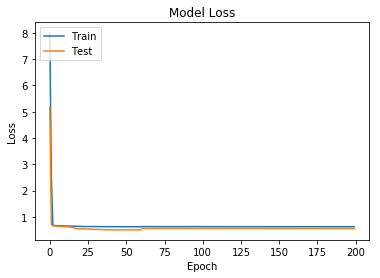

In [30]:
# Plot training & validation accuracy values
plt.plot(training2_data.history['loss'])
plt.plot(training2_data.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Entrenamos el modelo

In [31]:
model = model_arquitecture()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                352       
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                352       
______________________________

In [32]:
training = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

Train on 146 samples, validate on 37 samples
Epoch 1/100
 - 0s - loss: 0.6794 - acc: 0.5890 - val_loss: 0.5557 - val_acc: 0.7297
Epoch 2/100
 - 0s - loss: 0.6613 - acc: 0.6575 - val_loss: 0.5978 - val_acc: 0.7297
Epoch 3/100
 - 0s - loss: 0.6510 - acc: 0.6575 - val_loss: 0.6054 - val_acc: 0.7297
Epoch 4/100
 - 0s - loss: 0.6388 - acc: 0.6575 - val_loss: 0.5448 - val_acc: 0.7297
Epoch 5/100
 - 0s - loss: 0.6446 - acc: 0.6575 - val_loss: 0.5313 - val_acc: 0.7297
Epoch 6/100
 - 0s - loss: 0.6272 - acc: 0.6575 - val_loss: 0.5660 - val_acc: 0.7297
Epoch 7/100
 - 0s - loss: 0.6209 - acc: 0.6575 - val_loss: 0.5362 - val_acc: 0.7297
Epoch 8/100
 - 0s - loss: 0.6058 - acc: 0.6644 - val_loss: 0.4979 - val_acc: 0.7838
Epoch 9/100
 - 0s - loss: 0.6043 - acc: 0.6986 - val_loss: 0.4828 - val_acc: 0.7838
Epoch 10/100
 - 0s - loss: 0.5684 - acc: 0.7397 - val_loss: 0.4688 - val_acc: 0.7838
Epoch 11/100
 - 0s - loss: 0.5651 - acc: 0.7055 - val_loss: 0.4483 - val_acc: 0.8649
Epoch 12/100
 - 0s - loss: 0.

Epoch 97/100
 - 0s - loss: 0.4095 - acc: 0.7808 - val_loss: 0.3872 - val_acc: 0.7838
Epoch 98/100
 - 0s - loss: 0.3834 - acc: 0.7945 - val_loss: 0.3240 - val_acc: 0.8378
Epoch 99/100
 - 0s - loss: 0.3927 - acc: 0.7740 - val_loss: 0.3189 - val_acc: 0.7568
Epoch 100/100
 - 0s - loss: 0.3861 - acc: 0.8082 - val_loss: 0.3570 - val_acc: 0.8378
